# Data Preprocessing:
Given data as a csv from a postgres call, extract the relevant lab events, chunk the lab events into 4 hour increments and interpolate the amount at each time index based on the previous measurement

In [2]:
import numpy as np
import pandas as pd
import pickle

In [87]:
import sqlalchemy as db
from sqlalchemy import create_engine

engine = db.create_engine('connection string')
connection = engine.connect()
connection.execute("set search_path to mimiciii")

sepsis_admissions = pd.read_sql("select * from mimic_db.mimiciii.d_labitems", connection)

In [88]:
columnNames = ["row_id", "subject_id", "hadm_id", "itemid", "charttime", "value", "valuenum",
              "valueuom", "flag"]
rawData = pd.read_csv("mimic_db_mimiciii_sepsis_lab_events.csv", names = columnNames)

admitNames = ["hadm_id", "admittime", "dischtime"]
admissionTimes = pd.read_csv("sepsis_admissions_admit_time.csv", names = admitNames)
admissionTimes = admissionTimes.set_index('hadm_id')

In [89]:
rawData = rawData.astype({'value': str, 'valueuom': str, 'flag': str})

In [90]:
admissionTimes['admittime'] = pd.to_datetime(admissionTimes['admittime'])
admissionTimes['dischtime'] = pd.to_datetime(admissionTimes['dischtime'])

admissionTimes

,admittime,dischtime
hadm_id,,
185910,2166-08-10 00:28:00,2166-09-04 11:30:00
145674,2198-08-02 04:49:00,2198-10-26 14:55:00
122609,2198-11-01 22:36:00,2198-11-14 14:20:00
142807,2122-12-13 19:30:00,2123-03-04 13:47:00
160481,2128-03-17 17:11:00,2128-06-17 15:00:00
...,...,...
134977,2188-10-18 02:00:00,2188-10-22 15:53:00
186754,2143-08-22 16:01:00,2143-09-02 17:15:00
168288,2127-06-10 19:22:00,2127-06-18 11:51:00


In [91]:
admissionTimes.at[145674, 'admittime']

Timestamp('2198-08-02 04:49:00')

In [92]:
rawData['charttime'] = pd.to_datetime(rawData['charttime'])

In [5]:
rawData

,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,23565441,66745,192825,51237,2145-11-16 15:00:00,1.0,1.0,nan,nan
1,23565442,66745,192825,51248,2145-11-16 15:00:00,31.4,31.4,pg,nan
2,23565443,66745,192825,51249,2145-11-16 15:00:00,35.5,35.5,%,abnormal
3,23565444,66745,192825,51250,2145-11-16 15:00:00,88,88.0,fL,nan
4,23565445,66745,192825,51265,2145-11-16 15:00:00,55,55.0,K/uL,abnormal
...,...,...,...,...,...,...,...,...,...
3466296,23565436,66745,192825,50986,2145-11-16 15:00:00,LESS THAN 2.0,NaN,ng/mL,nan
3466297,23565437,66745,192825,51006,2145-11-16 15:00:00,19,19.0,mg/dL,nan
3466298,23565438,66745,192825,51214,2145-11-16 15:00:00,302,302.0,mg/dL,nan
3466299,23565439,66745,192825,51221,2145-11-16 15:00:00,33.9,33.9,%,abnormal


In [6]:
len(rawData['hadm_id'].unique())

4134

In [261]:
# Lookup table to convert lab itemid's to a specific feature
# Metavision data only - 2077 cases
featureIds = [
    51221, # Hematocrit
    51301, # White Blood Cell Blood
    51516, # WBC Urine
    51222, #Hemoglobin
    51250, #MCV
    51249, #MCHC
    51277, #RDW
    51265, #Platelet Count
    51248, #MCH
    51279, #Red Blood Cell Blood
    51493, # RBC Urine
    50971, #Potassium
    50983, #Sodium
    50902, #Chloride
    50882, #Bicarbonate
    50868, #Anion Gap
    51006, #Urea Nitrogen
    50912, #Creatinine
    50893, #Calcium, Total
    51146, #Basophils
    51256, #Neutrophils
    51244, #Lymphocytes
    51254, #Monocytes
    51200, #Eosinophils
    50970, #Phosphate
    50931, #Glucose Blood
    51478, #Glucose Urine
    50960, #Magnesium
    51237, #INR(PT)
    51274, #PT
    51275, #PTT
    50885, #Bilirubin Blood
    51464, #Bilirubin Urine
    50813, #Lactate
    50863, #Alkaline Phosphatase
    50878, #Asparate Aminotransferase (AST)
    50861, #Alanine Aminotransferase (ALT)
    51491, #pH Urine
    50820, #pH Blood
    51498, #Specific Gravity
    50821, #pO2
    50804, #Calculated Total CO2
    50802, #Base Excess
    50818, #pC02
    50862, #Albumin
    51492, #Protein
    51519, #Yeast
    51476, #Epithelial Cells
    51144, #Bands
    50954, #Lactate Dehydrogenase (LD)
    51514, #Urobilinogen
    51484, #Ketone
    50910, #Creatine Kinase (CK)
    51506, #Urine Appearance
    51486 #Leukocytes
]



def normalize_rbc_wbc_urine(val):
    special_cases = '-><'
    try:
        if any(ch in val for ch in special_cases):
            if '-' in val:
                lower_bound = float(val.split('-')[0])
                upper_bound = float(val.split('-')[1])
                return (upper_bound + lower_bound) / 2
            if '<' in val:
                return float(val.split('<')[1]) - 1
            if '>' in val:
                return float(val.split('>')[1]) + 1
    except:
        return float(val)
    
def normalize_other_urine(val):
    try:
        if val is 'NEG' or val is 'TR':
            return 0.0
        else:
            if '>' in val:
                return float(val.split('>')) + 1
            return float(val)
    except:
        return 0.0
    
def normalize_yeast(val):
    if val is 'NONE':
        return 0.0
    if val is 'RARE':
        return 1.0
    if val is 'FEW':
        return 2.0
    if val is 'OCC' or val is 'MOD':
        return 3.0
    if val is 'MANY':
        return 4.0
    return 0.0

def normalize_epithelial_cells(val):
    try:
        return normalize_rbc_wbc_urine(val)
    except:
        return 0.0

def normalize_leukocytes(val):
    if val is 'NEG':
        return 0.0
    if val is 'TR':
        return 1.0
    if val is 'SM':
        return 2.0
    if val is 'MOD':
        return 3.0
    if val is 'LG':
        return 4.0
    return 0.0

def normalize_urine_appearance(val):
    return [is_urine_clear(val), 
            is_urine_hazy(val),
            is_urine_cloudy(val)]
    
def is_urine_clear(val):
    desc = {'Clear', 'CLEAR', 'CL'}
    if val in desc:
        return 1.0
    else:
        return 0.0

def is_urine_hazy(val):
    desc = {'Hazy', 'SlHazy', 'HAZY', 'SLHAZY'}
    if val in desc:
        return 1.0
    else:
        return 0.0
    
def is_urine_cloudy(val):
    desc = {'Cloudy', 'SlCldy', 'SlCloudy', 'Slcldy', 'CLOUDY', 'CLO'}
    if val in desc:
        return 1.0
    else:
        return 0.0

customExtraction = {
    51516: normalize_rbc_wbc_urine,
    51493: normalize_rbc_wbc_urine,
    51478: normalize_other_urine,
    51492: normalize_other_urine,
    51519: normalize_yeast,
    51476: normalize_epithelial_cells,
    51514: normalize_other_urine,
    51484: normalize_other_urine,
    51506: normalize_urine_appearance,
    51486: normalize_leukocytes
}

def extractFeature(df):
    x = []
    df = df.set_index('itemid')
    for i, feature in enumerate(featureIds):
        val = -1.0
        float_val = -1.0
        
        try:
            val = df.at[feature, 'value']
        except:
            val = -1.0
        
        #qResult = df.loc[df['itemid'] == feature]
        #if not qResult.empty:
         #   val = qResult.iloc[0]['value']
        try:
            if feature in customExtraction.keys():
                float_val = customExtraction[feature](val)
                if feature == 51506:
                    for one_hot in float_val:
                        x.append(one_hot)
                else:
                    x.append(float_val)
            else:
                x.append(float(val))
        except:
            x.append(-1.0)
    return np.asarray(x)

In [262]:
featureIds[39]

51498

In [263]:
featureIds[53]

51506

In [ ]:
admissionTimes.at[]

In [94]:
xTrain = {}
for patient in rawData['hadm_id'].unique():
    patientRows = rawData.loc[rawData['hadm_id'] == patient].sort_values(by=['charttime'])
    startTime = admissionTimes.at[patient, 'admittime']
    endTime = admissionTimes.at[patient, 'dischtime']
    #startTime = patientRows.iloc[0]['charttime']
    #endTime = patientRows.iloc[len(patientRows)-1]['charttime']
    
    # build 4 hour incremental feature vectors between start and end time
    bucketedTimes = {}
    currentTime = startTime;
    index = 0
    while(currentTime < endTime):
        startInterval = currentTime;
        endInterval = currentTime + np.timedelta64(4, 'h')
        bucketInterval = patientRows.loc[patientRows['charttime'] >= startInterval].loc[patientRows['charttime'] < endInterval]
        bucketedTimes[index] = extractFeature(bucketInterval)
        currentTime += np.timedelta64(4, 'h')
        index += 1
    xTrain[patient] = bucketedTimes
    
# TODO normalize timesteps into t0, t1, t2, etc.
# TODO fix data into floats numpy float array
# TODO quantify the non-number data using either one hot or scale
# Use a pickle file to store the training set\
# with open('fname', 'wb') as f:
#    pickle.dump(xTrain, f)

with open('training_lab_data.pkl', 'wb') as f:
    pickle.dump(xTrain, f)


In [95]:
xTrain[190893]

{0: array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.,  0.,  0., -1., -1., -1.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.]),
 1: array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.,  0.,  0., -1., -1., -1.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.]),
 2: array([ 24.8 ,   8.4 ,  -1.  ,   8.3 ,  82.  ,  33.4 ,  16.  , 261.  ,
         27.2 ,   3.04,  -1.  ,   2.6 , 142.  , 119.  ,  13.  ,  13.  ,
         20.  ,   2.  ,   7.7 ,  -1.  ,  -1.  ,  -1.  ,  -1.  ,  -1.  ,
          1.2 , 140.  ,   0.  ,   2.  ,   1.2 ,  14.4 ,  40.9 ,   0.4 ,
         -1.  ,  -1.  ,  75.  ,  11.  ,   3.  ,  

In [59]:
patientRows.loc[patientRows['charttime'] >= start].loc[patientRows['charttime'] < end]

,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
87231,23561502,66745,192825,50970,2145-09-01 21:35:00,4.1,4.1,mg/dL,delta
87217,23561488,66745,192825,50863,2145-09-01 21:35:00,64,64.0,IU/L,nan
87218,23561489,66745,192825,50868,2145-09-01 21:35:00,14,14.0,mEq/L,nan
87219,23561490,66745,192825,50878,2145-09-01 21:35:00,50,50.0,IU/L,abnormal
87220,23561491,66745,192825,50882,2145-09-01 21:35:00,19,19.0,mEq/L,abnormal
...,...,...,...,...,...,...,...,...,...
89801,23561547,66745,192825,50821,2145-09-01 22:09:00,97,97.0,mm Hg,nan
89795,23561541,66745,192825,50804,2145-09-01 22:09:00,22,22.0,mEq/L,nan
89802,23561548,66745,192825,51082,2145-09-02 01:30:00,115,115.0,mg/dL,nan
89803,23561549,66745,192825,51087,2145-09-02 01:30:00,RANDOM,NaN,nan,nan


In [11]:
patientRows['itemid'].value_counts()

50800    176
50971    175
51221    175
50983    172
50868    170
        ... 
51216      1
51208      1
51076      1
51000      1
51438      1
Name: itemid, Length: 182, dtype: int64

In [96]:
with open('training_lab_data.pkl', 'rb') as f:
    xTrain = pickle.load(f)

xTrain_array = {}
i = 0
for hadm_id in xTrain:
    try:
        xTrain_array[hadm_id] = np.stack(xTrain[hadm_id].values(), axis=0)
    except:
        s = {}
        j = 0
        for val, i in enumerate(xTrain[hadm_id].keys()):
            if len(xTrain[hadm_id][i]) == 57:
                s[i] = xTrain[hadm_id][i]
            else:
                # copy the next available valid data point
                if i == 0:
                    k = i + 1
                    while k < len(xTrain[hadm_id]):
                        if len(xTrain[hadm_id][k]) == 57:
                            s[i] = xTrain[hadm_id][k]
                            break;
                        k = k + 1
                else: # take the previous valid data point
                    k = i - 1
                    while k >= 0:
                        if len(xTrain[hadm_id][k]) == 57:
                            s[i] = xTrain[hadm_id][k]
                            break;
                        k = k - 1
                j+=1
        if len(s) != 0:
            xTrain_array[hadm_id] = np.stack(s.values(), axis=0)
        print(str(hadm_id) + " replaced " + str(j) + " rows of " + str(len(xTrain[hadm_id].keys())))

with open('lab_event_training_set.pkl', 'wb') as f:
    pickle.dump(xTrain_array, f)

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


190893 replaced 1 rows of 66
136542 replaced 1 rows of 262
146708 replaced 0 rows of 0
111413 replaced 1 rows of 19
120221 replaced 1 rows of 47
125502 replaced 1 rows of 164
105003 replaced 1 rows of 149
142712 replaced 1 rows of 128
194687 replaced 1 rows of 95
191159 replaced 1 rows of 18
108160 replaced 1 rows of 97
165276 replaced 1 rows of 96
196951 replaced 1 rows of 59
140833 replaced 1 rows of 153
198555 replaced 0 rows of 0
102256 replaced 1 rows of 165
109022 replaced 1 rows of 72
110364 replaced 1 rows of 165
176558 replaced 1 rows of 130
104850 replaced 1 rows of 153
181572 replaced 1 rows of 216
195579 replaced 1 rows of 77
162989 replaced 1 rows of 54
140887 replaced 1 rows of 101
181672 replaced 0 rows of 0
125239 replaced 2 rows of 19
144708 replaced 1 rows of 66
159708 replaced 1 rows of 45
168548 replaced 0 rows of 0
113905 replaced 1 rows of 252
130903 replaced 0 rows of 0
116181 replaced 1 rows of 17
123318 replaced 1 rows of 181
114834 replaced 1 rows of 139
10501

In [97]:
with open('lab_event_training_set.pkl', 'rb') as f:
    lab_event_training_set = pickle.load(f)

In [98]:
event_data = lab_event_training_set[192825]

In [99]:
for hadm_id in lab_event_training_set:
    most_recent = lab_event_training_set[hadm_id][0]
    for row in lab_event_training_set[hadm_id]:
        row[row == -1] = most_recent[row == -1]
        most_recent = row
    

In [100]:
with open('lab_event_training_set_interpolated.pkl', 'wb') as f:
    pickle.dump(lab_event_training_set, f)

# Merging Training Sets:

Loads all the training sets, combines them

In [2]:
import numpy as np
import pandas as pd
import pickle

In [6]:
with open('lab_event_training_set_interpolated.pkl', 'rb') as f:
    train_lab_event = pickle.load(f)
    
with open('elixhauser_score.pkl', 'rb') as f:
    train_elixhauser_score = pickle.load(f)
    
with open ('fluids_chunked.pkl', 'rb') as f:
    train_fluids = pickle.load(f)

with open ('vasopressin_chunked.pkl', 'rb') as f:
    train_vasopressin = pickle.load(f)
    
with open ('vitals_chunked.pkl', 'rb') as f:
    train_vitals = pickle.load(f)

In [214]:
train_lab_event[100223][1]

array([ 3.430e+01,  4.650e+01, -1.000e+00,  9.800e+00,  9.100e+01,
        2.860e+01,  1.500e+01,  5.010e+02,  2.590e+01,  3.790e+00,
       -1.000e+00,  4.800e+00,  1.420e+02,  1.120e+02,  1.500e+01,
        2.000e+01,  5.600e+01,  1.700e+00,  6.900e+00,  4.000e-01,
        9.590e+01,  2.500e+00,  1.200e+00,  0.000e+00,  5.100e+00,
        1.280e+02,  0.000e+00,  1.900e+00,  1.800e+00,  1.920e+01,
        5.540e+01,  6.000e-01, -1.000e+00, -1.000e+00,  1.190e+02,
        6.000e+02,  1.110e+02, -1.000e+00, -1.000e+00, -1.000e+00,
       -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,  1.800e+00,
        0.000e+00,  0.000e+00, -1.000e+00, -1.000e+00,  1.689e+03,
        0.000e+00,  0.000e+00, -1.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00])

In [215]:
train_lab_event.keys()

dict_keys([192825, 131118, 167944, 117412, 146594, 132488, 166808, 107820, 121572, 161512, 119137, 141903, 117259, 145445, 119210, 176130, 100416, 172789, 128331, 172309, 147901, 100347, 117918, 173568, 120770, 197531, 166019, 134830, 140233, 105518, 191203, 150489, 178527, 167582, 185555, 190470, 199528, 123859, 155768, 183205, 117107, 130438, 122154, 183670, 174373, 194117, 104521, 188553, 112698, 194713, 199605, 105417, 173812, 147914, 149548, 143269, 181366, 174760, 186176, 159850, 144912, 163626, 126778, 142011, 157255, 143872, 141292, 191607, 107832, 153520, 161586, 161407, 123252, 193576, 166782, 104910, 148062, 136843, 190279, 158549, 138977, 156856, 195536, 121962, 149819, 137938, 152934, 100619, 147281, 105883, 174478, 182954, 175845, 188352, 149123, 136946, 174441, 114838, 161507, 113467, 129878, 103986, 153556, 153514, 145699, 162746, 127116, 188451, 171324, 109505, 127868, 113652, 186658, 155851, 191071, 143628, 190893, 146330, 185071, 160505, 125393, 146107, 176259, 11036

In [216]:
len(train_vasopressin)

546

In [217]:
len(train_lab_event)

4125

In [218]:
len(train_fluids)

2077

In [219]:
len(train_lab_event)

4125

In [220]:
len(train_vasopressin)

546

In [221]:
len(train_vitals)

2082

In [222]:
len(train_lab_event[102019])

120

In [223]:
for hadm_id in train_vasopressin.keys():
    if hadm_id in train_lab_event.keys():
        diff = len(train_vasopressin[hadm_id]) - len(train_lab_event[hadm_id])
        if diff != 0:
            print("Difference for hadm_id %d:\t%d" % (hadm_id, diff))

Difference for hadm_id 144435:	1
Difference for hadm_id 189288:	1
Difference for hadm_id 196043:	1


In [225]:
errors = 0;
for hadm_id in train_vitals.keys():
    if hadm_id in train_lab_event.keys():
        diff = len(train_lab_event[hadm_id]) - len(train_vitals[hadm_id]['bp_diastolic'])
        if diff != 0:
            print("%d has different length timesteps" % hadm_id)
            print("Length of Vitals: \t %d" % len(train_vitals[hadm_id]['bp_diastolic']))
            print("Length of Lab Event: \t %d" % len(train_lab_event[hadm_id]))
            errors = errors + 1
    else:
        print("%d is missing in the lab event data" % hadm_id)
        errors = errors + 1
        
print("\nTotal keys checked:\t%d" % len(train_vitals.keys()))
print("Total discrepancies:\t%d" % errors)

100326 has different length timesteps
Length of Vitals: 	 27
Length of Lab Event: 	 26
108873 has different length timesteps
Length of Vitals: 	 138
Length of Lab Event: 	 137
110084 is missing in the lab event data
119060 has different length timesteps
Length of Vitals: 	 11
Length of Lab Event: 	 10
125785 has different length timesteps
Length of Vitals: 	 62
Length of Lab Event: 	 61
127122 is missing in the lab event data
128262 has different length timesteps
Length of Vitals: 	 60
Length of Lab Event: 	 59
132104 has different length timesteps
Length of Vitals: 	 185
Length of Lab Event: 	 184
134497 has different length timesteps
Length of Vitals: 	 56
Length of Lab Event: 	 55
138301 is missing in the lab event data
138376 has different length timesteps
Length of Vitals: 	 190
Length of Lab Event: 	 189
144435 has different length timesteps
Length of Vitals: 	 518
Length of Lab Event: 	 517
146708 is missing in the lab event data
147884 has different length timesteps
Length of V

In [226]:
vitals_ad = train_vitals.keys()
fluids_ad = train_fluids.keys()
lab_event_ad = train_lab_event.keys()

valid_hadm_id = {''}
for leKey in lab_event_ad:
    if leKey in vitals_ad and leKey in fluids_ad:
        valid_hadm_id.add(leKey)
valid_hadm_id.remove('')

In [227]:
len(valid_hadm_id)

2070

In [ ]:
# New feature vector per time step:
# lab event feature : 57 floats
# vital : 'bp_diastolic'
# vital : 'bp_mean'
# vital : 'bp_systolic'
# vital : 'temperature'
# vital : 'hr'



In [228]:
unique_keys = {''}
for hadm_id in train_vitals:
    for vital in train_vitals[hadm_id]:
        unique_keys.add(vital)
unique_keys.remove('')

In [229]:
unique_keys

{'bp_diastolic', 'bp_mean', 'bp_systolic', 'hr', 'temperature'}

## def combineFeatures(hadm_id):
    vitals = {'bp_diastolic', 'bp_mean', 'bp_systolic', 'temperature' , 'hr'}
    patient = train_lab_event[hadm_id]
    vital_data = np.empty((5,))
    for i in range(len(patient)):
        vital_row = np.empty(5,)
        for j, v in enumerate(vitals):
            try:
                vital_row[j] = train_vitals[hadm_id][v][i]
            except:
                vital_row[j] = np.nan
        if i == 0:
            vital_data = vital_row
        else:
            vital_data = np.vstack((vital_data, vital_row))
    if vital_data.ndim != 1:
        return np.hstack((train_lab_event[hadm_id], vital_data))
    else:
        return np.append(train_lab_event[hadm_id], vital_data)

In [207]:
len(train_lab_event[100223][0])

57

In [241]:
train_merged = {}
for hadm_id in valid_hadm_id:
    train_merged[hadm_id] = combineFeatures(hadm_id)

In [242]:
for key in train_merged:
    if train_merged[key].ndim != 1:
        if train_merged[key].shape[1] != 62:
            print("2D array wrong size: " + str(train_merged[key].shape))
    else:
        if len(train_merged[key]) != 62:
            print("1D array wrong size: %d", len(train_merged[key]))

In [243]:
with open('training_set.pkl', 'wb') as f:
    pickle.dump(train_merged, f)

# Label Fixing:
Verifying that a label exists per data point, and in the case that they dont, zero's are added as vasopressin and fluids as missing cases means that nothing was administered

In [3]:
with open('training_set.pkl', 'rb') as f:
    train_set = pickle.load(f)

In [4]:
len(train_vasopressin)

NameError: name 'train_vasopressin' is not defined

In [7]:
len(train_fluids)

2077

In [5]:
len(train_set)

2070

In [9]:
train_set[100223].shape

(128, 62)

In [10]:
y_fluids = {}
for hadm_id in train_set.keys():
    if hadm_id not in train_fluids.keys():
        print("Missing " + str(hadm_id) + " in train_fluids")
    else:
        y_fluids[hadm_id] = train_fluids[hadm_id]

In [11]:
y_vasopressin = {}
for hadm_id in train_set.keys():
    if hadm_id in train_vasopressin.keys():
        y_vasopressin[hadm_id] = train_vasopressin[hadm_id]
    else:
        y_vasopressin[hadm_id] = np.zeros((train_set[hadm_id].shape[0],), dtype=np.float64)

In [12]:
with open('y_fluids.pkl', 'wb') as f:
    pickle.dump(y_fluids, f)

with open('y_vasopressin.pkl', 'wb') as f:
    pickle.dump(y_vasopressin, f)

In [13]:
len(y_fluids)

2070

# Model Implementation

Since our data is time-series, we will be using an RNN and LSTM to try and predict whether vasopressin was administered and how much fluid was drained.

In [14]:
# Getting maximum hospital stay over dataset
max_time = 0
for hadm_id in train_set.keys():
    if len(train_set[hadm_id]) > max_time:
        second_max = max_time
        max_time = len(train_set[hadm_id])
        

In [15]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression



In [16]:
col = ["hadm_id", "sex", "age"]
demographic_data = pd.read_csv("demographics.csv", names = col)

with open("elixhauser_score.pkl", "rb") as f:
    train_elixhauser_score = pickle.load(f)

In [17]:
demographic_data = demographic_data.set_index("hadm_id")

In [18]:
demographic_data

,sex,age
hadm_id,,
185910,M,76
145674,M,63
122609,M,64
142807,F,0
160481,F,0
...,...,...
134977,M,46
186754,F,84
168288,M,69


In [19]:
len(train_elixhauser_score)

4137

In [20]:
train_set.keys()

dict_keys([122883, 172044, 188434, 139284, 122900, 106517, 114712, 188451, 114726, 196649, 131118, 122926, 114737, 139318, 172088, 172089, 163900, 155715, 139333, 172104, 172111, 131151, 131162, 114783, 180321, 131184, 147569, 155768, 163960, 131203, 188553, 114831, 114838, 196758, 188571, 139427, 188587, 180396, 131246, 155832, 131262, 180414, 180416, 196803, 164038, 172232, 155851, 188623, 106711, 164055, 147673, 114911, 147681, 164065, 196834, 123110, 155880, 188649, 131308, 196850, 172278, 155894, 155897, 114939, 131328, 164098, 147721, 172298, 123147, 147724, 147727, 131346, 180499, 172309, 180512, 188706, 155940, 139580, 164156, 139583, 123200, 164163, 123204, 180551, 188769, 106860, 106862, 115054, 123252, 156024, 115071, 106883, 139660, 156046, 131471, 106899, 188820, 106900, 172439, 131484, 164256, 180652, 147884, 172462, 188849, 115122, 131510, 180663, 147901, 139712, 156099, 172485, 131525, 147914, 197071, 115152, 172508, 123360, 115169, 139755, 188912, 156152, 180732, 14797

In [21]:
binary_train_set = {}

def splitFeature(hadm_id):
    score = float(train_elixhauser_score[hadm_id])
    age = max(90.0,  float(demographic_data.at[hadm_id, 'age']))
    sex = 1.0 if demographic_data.at[hadm_id, 'sex'] is 'M' else 0.0
    arr = np.array([score, age, sex], dtype=np.float64)
    if train_set[hadm_id].ndim != 1:
        additionalFeat = np.tile(arr, (len(train_set[hadm_id]), 1))
    else:
        additionalFeat = arr.reshape(1,3)
    prevVasopressin = np.array([0.0], dtype=np.float64)
    for i, val in enumerate(y_vasopressin[hadm_id][:len(y_vasopressin[hadm_id]) - 1]):
        prevVasopressin = np.append(prevVasopressin, val)
    prevVasopressin = prevVasopressin.reshape(len(prevVasopressin), 1)
    trueVasopressin = y_vasopressin[hadm_id].reshape(len(prevVasopressin), 1)
    prevVasopressin = np.hstack((prevVasopressin, trueVasopressin))
    if additionalFeat.shape[0] != prevVasopressin.shape[0]:
        minLen = min(additionalFeat.shape[0], prevVasopressin.shape[0])
        featVec = np.hstack((additionalFeat[:minLen], prevVasopressin[:minLen]))
    else:
        featVec = np.hstack((additionalFeat, prevVasopressin.reshape(len(prevVasopressin), 2)))
    if train_set[hadm_id].ndim == 1:
        return np.hstack((train_set[hadm_id].reshape(1,62), featVec))
    else:
        return np.hstack((train_set[hadm_id], featVec))

In [441]:
binaryTraining = np.empty((66,1))
for i, hadm_id in enumerate(train_set.keys()):
    if i == 0:
        binaryTraining = splitFeature(hadm_id)
    else:
        nextFeature = splitFeature(hadm_id)
        try:
            if nextFeature.ndim == 1:
                binaryTraining = np.vstack((binaryTraining, nextFeature.reshape(1, 66)))
            else:
                binaryTraining = np.vstack((binaryTraining, nextFeature))
        except:
            print("error on id: " + str(hadm_id))

In [458]:
binaryTraining.shape

xTrain = binaryTraining[:, :66]
yTrain = binaryTraining[:, 66]

with open('binaryClassifierFlattenedData.pkl', 'wb') as f:
    pickle.dump(binaryTraining, f)

# Binary Classification
Using the flattened dataset to run binary classification with Logistic regression

In [7]:
with open('binaryClassifierFlattenedData.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
import random

#shuffle dataset
random.Random(4).shuffle(data)

In [9]:
data = data.astype(np.float64)

In [10]:
data

array([[ 4.320e+01,  1.100e+01, -1.000e+00, ...,  1.000e+00,  0.000e+00,
         0.000e+00],
       [ 4.320e+01,  1.100e+01, -1.000e+00, ...,  1.000e+00,  0.000e+00,
         0.000e+00],
       [ 3.070e+01,  6.700e+00, -1.000e+00, ...,  1.000e+00,  0.000e+00,
         0.000e+00],
       ...,
       [ 2.750e+01,  6.300e+00, -1.000e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 2.520e+01,  1.160e+01,  1.001e+03, ...,  1.000e+00,  0.000e+00,
         0.000e+00],
       [ 2.360e+01,  4.000e-01, -1.000e+00, ...,  1.000e+00,  0.000e+00,
         0.000e+00]])

In [11]:
cleanData = data[~np.isnan(data).any(axis=1)]

In [13]:
cleanData.shape

(70110, 67)

In [187]:
positives = cleanData[cleanData[:, 66] == 1.0]
negatives = cleanData[cleanData[:, 66] == 0.0]
negatives_test = negatives[:400]
negatives_valid = negatives[400:1200]
negatives_train = negatives[1200:]

positives_test = positives[:6800]
positives_valid = positives[6800:20400]
positives_train = positives[20400:]

In [188]:
# 66314 negatives
# 3796 positives

In [189]:
balanced_train = negatives_train
balanced_valid = negatives_valid
balanced_test = negatives_test
balanced_data = negatives
for i in range(17):
    balanced_data = np.vstack([balanced_data, positives])
    balanced_train = np.vstack([balanced_train, positives_train])
    balanced_valid = np.vstack([balanced_valid, positives_valid])
    balanced_test = np.vstack([balanced_test, positives_test])
    
print(balanced_data[balanced_data[:, 66] == 1].shape)
print(balanced_data.shape)


(64532, 67)
(130846, 67)


In [205]:
np.random.seed(4)
np.random.shuffle(balanced_train)
np.random.shuffle(balanced_valid)
np.random.shuffle(balanced_test)
np.random.shuffle(balanced_data)

In [206]:
#split features and labels

x = balanced_data[:, :65]
y = balanced_data[:, 66]

#set labels to {0,1}
for i in range(len(y)):
    if y[i] > 0:
        y[i] = 1.0
    else:
        y[i] = 0
        
# 182296 points
# training: 50000
# validation: 15000
# test: remaining 5110

train_cutoff = 95000
valid_cutoff = train_cutoff + 25000

xTrain = x[:train_cutoff, :]
yTrain = y[:train_cutoff]
xValid = x[train_cutoff:valid_cutoff, :]
yValid = y[train_cutoff:valid_cutoff]
xTest = x[valid_cutoff:, :]
yTest = y[valid_cutoff:]


In [207]:
y[y == 1.0].shape

(64532,)

In [208]:
yTrain.shape

(95000,)

In [209]:
xTrain.shape

(95000, 65)

In [210]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [211]:
pca = PCA(n_components=10)
pca.fit(xTrain)
xPCA_train = pca.transform(xTrain)
xPCA_valid = pca.transform(xValid)

In [212]:
yTrain[yTrain[:] == 0.0].shape

(48071,)

In [213]:
clf_pca = LogisticRegression(penalty = 'l2').fit(xPCA_train, yTrain)
clf = LogisticRegression(penalty = 'l2').fit(xTrain, yTrain)
clf_lda = LDA()
clf_lda.fit(xTrain,yTrain)
clf_pca_lda = LDA()
clf_pca_lda.fit(xPCA_train, yTrain)
clf_linear = LinearRegression(fit_intercept = True, normalize=True).fit(xTrain,yTrain)
clf_linear_pca = LinearRegression(fit_intercept = True, normalize = True).fit(xPCA_train, yTrain)

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

In [214]:
logistic_predictions_pca = clf_pca.predict(xPCA_valid)
logistic_predictions = clf.predict(xValid)
lda_predictions = clf_lda.predict(xValid)
linear_predictions = clf_linear.predict(xValid)
linear_predictions_pca = clf_linear_pca.predict(xPCA_valid)
pca_lda_predictions = clf_pca_lda.predict(xPCA_valid)

In [215]:
yValid.shape

(25000,)

In [216]:
def calculateAccuracy(predictions, truth):
    correct = 0
    wrong = 0
    total = 0
    for i, p in enumerate(predictions):
        if predictions[i] == truth[i]:
            correct = correct + 1
        else:
            wrong = wrong + 1
        total = total + 1
    print(str(correct) + " of " + str(total) + " predicted correctly")
    print("Accuracy: " + str(correct/total))
    
def calculateLinear(predictions, truth):
    correct = 0
    wrong = 0
    total = 0
    for i, p in enumerate(predictions):
        pred = predictions[i] > 0
        tru = truth[i] == 1
        if pred == tru:
            correct = correct + 1
        else:
            wrong = wrong + 1
        total = total + 1
    print(str(correct) + " of " + str(total) + " predicted correctly")
    print("Accuracy: " + str(correct/total))

In [217]:
print("LDA")
calculateAccuracy(lda_predictions, yValid)

print("\nLogistic PCA")
calculateAccuracy(logistic_predictions_pca, yValid)

print("\nLogistic")
calculateAccuracy(logistic_predictions, yValid)

print("\nLinear")
calculateLinear(linear_predictions, yValid)

print("\nLinear PCA")
calculateLinear(linear_predictions_pca, yValid)

print("\nLinear PCA+LDA")
calculateAccuracy(pca_lda_predictions, yValid)

LDA
20823 of 25000 predicted correctly
Accuracy: 0.83292

Logistic PCA
18351 of 25000 predicted correctly
Accuracy: 0.73404

Logistic
20315 of 25000 predicted correctly
Accuracy: 0.8126

Linear
14168 of 25000 predicted correctly
Accuracy: 0.56672

Linear PCA
12785 of 25000 predicted correctly
Accuracy: 0.5114

Linear PCA+LDA
17761 of 25000 predicted correctly
Accuracy: 0.71044


In [218]:
T = clf_lda.coef_
T2 = clf_pca_lda.coef_

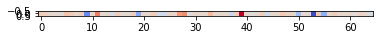

In [243]:
import matplotlib.pyplot as plt
plt.imshow(clf_lda.coef_, cmap='coolwarm', interpolation='nearest')
plt.show()

In [258]:
mini = 0
maxi = 0
for i, e in enumerate(T[0]):
    if e == np.amin(T[0]):
        mini = i
    if e == np.amax(T[0]):
        maxi = i

In [264]:
mini

53

In [257]:
np.amax(T[0])

0.6821495516533453

In [221]:
xTrainLDA = np.sum(xTrain*T, axis=1).reshape(95000,1)
xValidLDA = np.sum(xValid*T, axis=1).reshape(25000,1)
clf_logistic_lda = LogisticRegression(penalty = 'l2').fit(xTrainLDA, yTrain)
#clf = LogisticRegression(penalty = 'l2').fit(xTrain, yTrain)
predictions_logistic_lda = clf_logistic_lda.predict(xValidLDA)
calculateAccuracy(predictions_logistic_lda, yValid)

20875 of 25000 predicted correctly
Accuracy: 0.835


In [222]:
xTrainPCA_LDA = np.sum(xPCA_train*T2, axis=1).reshape(95000,1)
xValidPCA_LDA = np.sum(xPCA_valid*T2, axis=1).reshape(25000,1)
clf_logistic_pca_lda = LogisticRegression(penalty='l2').fit(xTrainPCA_LDA, yTrain)
predictions_log_pca_lda = clf_logistic_pca_lda.predict(xValidPCA_LDA)
calculateAccuracy(predictions_log_pca_lda, yValid)

17714 of 25000 predicted correctly
Accuracy: 0.70856


In [223]:
pca.components_

array([[ 3.58896652e-06,  2.53332096e-05, -9.46553488e-05,
         8.58527788e-06, -2.75113820e-05, -8.16342545e-06,
        -9.20629636e-05, -3.33138689e-03,  1.09537181e-06,
        -2.34653398e-07, -8.88851863e-05, -7.89698540e-07,
        -6.15597392e-05, -1.17339179e-04, -1.53095737e-04,
         2.03754915e-04, -1.46724913e-04,  1.61095975e-05,
        -5.38493810e-05, -4.84230851e-06, -3.00434148e-04,
         4.57091413e-05, -2.76776202e-05, -3.07440209e-05,
         2.70356254e-05,  1.24466403e-03, -2.29663073e-06,
        -3.97028737e-07,  2.29363597e-05,  2.12777177e-04,
         5.60030294e-04, -8.24381791e-05, -0.00000000e+00,
         9.69381709e-05, -1.81919759e-03,  4.73152640e-02,
         1.23276992e-02, -3.94532785e-05,  1.03702438e-05,
        -1.26533687e-05,  7.08350731e-04, -7.15479866e-05,
        -1.84112502e-04,  4.14442485e-05, -1.94932081e-05,
        -4.84820947e-06, -0.00000000e+00, -2.24460825e-05,
         1.33991536e-04,  3.92606438e-02, -4.67261800e-0

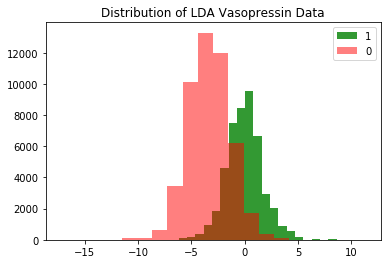

In [224]:
plt.hist(xTrainLDA[yTrain == 1], bins=20, color='g', alpha=0.8, label='1')
plt.hist(xTrainLDA[yTrain == 0], bins=20, color='r', alpha=0.5, label='0')
plt.legend(loc='upper right')
plt.title("Distribution of LDA Vasopressin Data")
plt.show()

In [225]:
len(xTrainLDA[yTrain==1])

46929

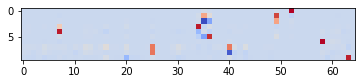

In [226]:
plt.imshow(pca.components_, cmap='coolwarm', interpolation='nearest')

In [227]:
correct/total

NameError: name 'correct' is not defined

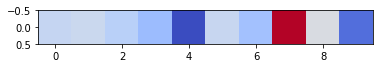

In [228]:
plt.imshow(clf_pca_lda.coef_, cmap='coolwarm', interpolation='nearest')

In [229]:
from sklearn.ensemble import RandomForestClassifier

In [230]:
#xTrainLDA, xValidLDA
clf = RandomForestClassifier(oob_score=True)

In [231]:
clf.fit(xTrainLDA, yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [232]:
forestPred = clf.predict(xValidLDA)

In [233]:
calculateAccuracy(forestPred, yValid)

24798 of 25000 predicted correctly
Accuracy: 0.99192


In [234]:
clf.feature_importances_

array([1.])

In [235]:
from sklearn.ensemble import AdaBoostClassifier
clf_boost = AdaBoostClassifier()
clf_boost.fit(xTrainLDA, yTrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [236]:
boostPred = clf_boost.predict(xValidLDA)

In [237]:
calculateAccuracy(boostPred, yValid)

20928 of 25000 predicted correctly
Accuracy: 0.83712


In [239]:
from sklearn import svm
clf = svm.SVC()
clf.fit(xTrainLDA, yTrain)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [240]:
svmPred = clf.predict(xValidLDA)

In [242]:
calculateAccuracy(svmPred, yValid)

20804 of 25000 predicted correctly
Accuracy: 0.83216


#### 